## Downloading dataset

In [ ]:
#fetch data 
from sklearn.datasets import fetch_openml

# MNIST dataset
mnist = fetch_openml('mnist_784', version=1)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = mnist['data'].to_numpy().astype(float) 
y = mnist['target'].to_numpy().astype(int)

In [86]:
# display the shape of data and labels
print(f"Data shape: {X.shape}")
print(f"Labels shape: {y.shape}")

# display the first few labels
print(f"First 10 labels: {y[:10]}")

Data shape: (70000, 784)
Labels shape: (70000,)
First 10 labels: [5 0 4 1 9 2 1 3 1 4]


## Visualising sample images 

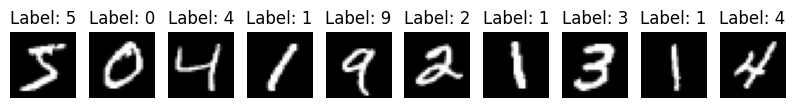

In [87]:
import matplotlib.pyplot as plt

#function to plot sample images
def plot_digits(X, y, num=10):
    plt.figure(figsize=(10, 1))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.imshow(X[i].reshape(28, 28), cmap="gray")
        plt.title(f"Label: {y[i]}")
        plt.axis("off")
    plt.show()

    
plot_digits(X,y)


Each image has 784 features so theyre already flattened

## Normalise pixel values in the range 0 to 1

In [88]:
X = X /225.0
#colors range from values 0 to 255 (black to white)


## Apply PCA to reduce dimensions 

In [89]:
from sklearn.decomposition import PCA

#consider 50 components for simplicity
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)


## Split dataset

In [90]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2


## Applying KNN from scratch

Create a class for KNN where the initialiser makes use of K which is the number of nearest nuumbers to consider when making a prediction. The default value is considered 3. 
The store_data fubtion initialises test and train data. 
euclidean distance makes use of the formula sqrt(sum(a - b)^2)
this calculation has been vectorised for speed. 
It finds teh points that are closes to b. 
a is a set of points and b is a single point for the values to be calculated against. 

teh predict function creates a prediction array and for each value in X it calculates the distances of the values around it and the indices. it then get the indices of the k closest points
fetches their labels usinf k_nearest_labels. 
then it counts how many times each label appears, picks the label that appears most frequently and adds it to the predictions list

it returns an array of all the predicted values. 

the score function returns accuracy score by calulating percentage of accurate preductions

In [91]:
import numpy as np

In [92]:
import numpy as np

class KNNClassifier:
    def __init__(self, k=3, weighted=False):
        self.k = k
        self.weighted = weighted

    def store_data(self, X, y):
        self.X_train = X
        self.y_train = y

    def euclidean_distance(self, X1, X2):
        # X1: training data (n_samples_train, n_features)
        # X2: test data (n_samples_test, n_features)
        X1_sq = np.sum(X1**2, axis=1).reshape(-1, 1)     # (n_train, 1)
        X2_sq = np.sum(X2**2, axis=1).reshape(1, -1)     # (1, n_test)
        cross = np.dot(X1, X2.T)                         # (n_train, n_test)
        dists = np.sqrt(X1_sq - 2 * cross + X2_sq)       # (n_train, n_test)
        return dists.T                                   # (n_test, n_train)

    def predict(self, X):
        distances = self.euclidean_distance(self.X_train, X)
        predictions = []

        for i in range(len(X)):
            k_indices = np.argsort(distances[i])[:self.k]
            k_nearest_labels = self.y_train[k_indices]

            if self.weighted:
                # Weight = 1 / distance
                weights = 1 / (distances[i][k_indices] + 1e-5)
                vote = {}
                for idx, label in enumerate(k_nearest_labels):
                    vote[label] = vote.get(label, 0) + weights[idx]
                predicted_label = max(vote, key=vote.get)
            else:
                values, counts = np.unique(k_nearest_labels, return_counts=True)
                predicted_label = values[np.argmax(counts)]

            predictions.append(predicted_label)

        return np.array(predictions)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)


## Testing with different values of K 

In [94]:
knn = KNNClassifier(k=5, weighted=True)
knn.store_data(X_train, y_train)
accuracy = knn.score(X_val, y_val)
print("Validation Accuracy:", accuracy)


Validation Accuracy: 0.9714285714285714


              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1343
           1       0.97      0.99      0.98      1600
           2       0.98      0.97      0.98      1380
           3       0.96      0.96      0.96      1433
           4       0.97      0.96      0.97      1295
           5       0.96      0.97      0.96      1273
           6       0.98      0.99      0.99      1396
           7       0.96      0.97      0.97      1503
           8       0.98      0.93      0.96      1357
           9       0.95      0.96      0.95      1420

    accuracy                           0.97     14000
   macro avg       0.97      0.97      0.97     14000
weighted avg       0.97      0.97      0.97     14000



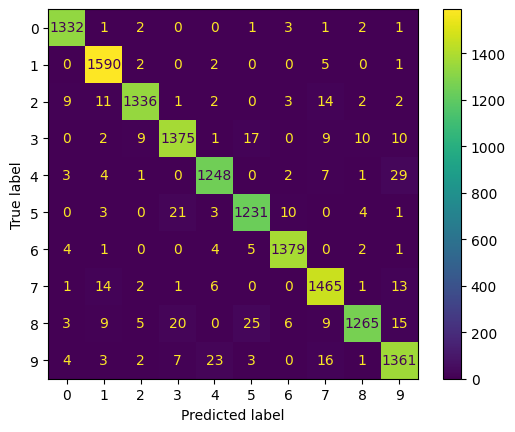

In [96]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

best_k = ks[np.argmax(accuracies)]
knn = KNNClassifier(k=best_k)
knn.store_data(X_train, y_train)
y_pred = knn.predict(X_test)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()


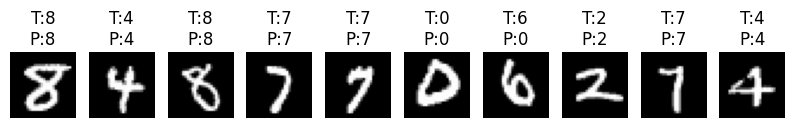

In [97]:
def plot_predictions(X, y_true, y_pred, num=10):
    plt.figure(figsize=(10, 1))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.imshow(X[i].reshape(28, 28), cmap="gray")
        plt.title(f"T:{y_true[i]}\nP:{y_pred[i]}")
        plt.axis("off")
    plt.show()

plot_predictions(X_test, y_test, y_pred)
